# COMP0124 MAAI Individual Coursework 

This 50-point individual coursework has four parts,
the Matrix Game, the Stochastic Game, the Nonzero-sum Game and Deep Multi-Agent Reinforcement Learning.

## Instructions
1.   To start this CW, please duplicate this notebook at first:
  - Choose "File => Save a copy in Drive" and open/run it in Colab.
  - Or you can download the notebook and run it in your local jupyter notebook server.
2.   For the coding assignment, please write your code at `### TODO ###` blocks or in a new cell. For analysis report, you are free to use as many blocks as you need.
3.   Before submitting your notebook, **make sure that it runs without errors**, we also provide a validation tool in the end of this notebook.
  - To check this, reload your notebook and the Python kernel, and run the notebook from the first to the last cell.
  - Please do not change any methods or variables' name in the notebook, otherwise, you cannot get marking correctly.
  - We would not help you debug the code, if we cannot run your submitted notebook, you will get zero point. 
4.  Download your notebook and submit it on Moodle.
  - Click on "File -> Download .ipynb".
  - Rename your notebook to ***firstname_lastname_studentnumber.ipynb***. (Please strictly follow the naming requirement.)
  - Upload to Moodle.
5. This CW would due by **23:55 26/03/2021**, please submit your .ipynb file through the [submission entrance](https://moodle.ucl.ac.uk/mod/assign/view.php?id=1685901).
6. If you have any questions, please contact TAs: [Minne Li](minne.li@cs.ucl.ac.uk), [Oliver Slumbers](o.slumbers@cs.ucl.ac.uk), [Xihan Li](xihan.li.20@ucl.ac.uk), [Xidong Feng](xidong.feng@cs.ucl.ac.uk), and [Mengyue Yang](m.yang@cs.ucl.ac.uk).

In [56]:
import math
from scipy import special

## Part I: Matrix Game (10 points)

We start with the simplest setting: Matrix Game (a.k.a Stage Game/Normal Form Game). In this part, you will try to solve the matrix game with full knowledge of the payoff for each player in the game.



Given a two-player, two-action matrix game, we have the payoff matrices as follows:
$$
\mathbf{R}^1 = \left[\begin{matrix}
0 & 3 \\
1 &2
\end{matrix}\right] 
\quad 
\mathbf{R}^2 = \left[\begin{matrix}
3 & 2 \\
0 & 1
\end{matrix}\right]
$$

Each player selects an action from the action space $\{1,2\}$ which determines the payoffs to the players. If the player 1 chooses action $i$ and the player 2 chooses action $j$, then the player 1 and player2 receive the rewards $r^1_{ij}$ and $r^2_{ij}$ respectively. For example, if both players choose action $1$, then the player 1 would have $r^1_{11}=0$ and player 1 would receive $r^2_{11}=3$.

Then, we can use $\alpha\in [0,1] $ represents the strategy for player 1, where $\alpha$ corresponds to the probability of player 1 selecting the first action (action 1), and $1-\alpha$ is the probability of choosing the second action (action 2). Similarly, we use $\beta$ to be the strategy for player 2.

Given the pair of strategies $(\alpha, \beta)$, we can have the expected payoffs for two players. Denote $V^1(\alpha, \beta)$ and $V^2(\alpha, \beta)$ as the expected payoffs for two players respectively:

$$
\begin{aligned} V^{1}(\alpha, \beta) &=\alpha \beta r^1_{11}+\alpha(1-\beta) r^1_{12}+(1-\alpha) \beta r^1_{21}+(1-\alpha)(1-\beta) r^1_{22} \\ &=u^1 \alpha \beta+\alpha\left(r^1_{12}-r^1_{22}\right)+\beta\left(r^1_{21}-r^1_{22}\right)+r^1_{22} \end{aligned}
$$
$$
\begin{aligned} V^{2}(\alpha, \beta) &=\alpha \beta r^2_{11}+\alpha(1-\beta) r^2_{12}+(1-\alpha) \beta r^2_{21}+(1-\alpha)(1-\beta) r^2_{22} \\ &=u^2 \alpha \beta+\alpha\left(r^2_{12}-r^2_{22}\right)+\beta\left(r^2_{21}-r^2_{22}\right)+r^2_{22}\end{aligned}
$$

where

$$
\begin{aligned} u^1 &=r^1_{11}-r^1_{12}-r^1_{21}+r^1_{22} \\  u^2 &=r^2_{11}-r^2_{12}-r^2_{21}+r^2_{22} .\end{aligned}
$$



#### Set up matrix game (4 points)



In [2]:
import numpy as np
from copy import deepcopy


def U(payoff):
    ########### TODO: Compute u (1 point) ###########
    u = payoff[0,0] - payoff[0,1] - payoff[1,0] + payoff[1,1]
    ########### END TODO ############################
    return u
  
    
# expected payoff
def V(alpha, beta, payoff):
    ########### TODO: Compute expected payoff of given strategies alpha and beta (1 point) ###########
    u = U(payoff)
    v = u*alpha*beta + alpha*(payoff[0,1]-payoff[1,1]) + beta*(payoff[1,0]-payoff[1,1]) + payoff[1,1]
    ########### END TODO ##############################################################################
    return v


payoff_0 = np.array([[0, 3], 
                     [1, 2]])
payoff_1 = np.array([[3, 2], 
                     [0, 1]])

pi_alpha = 0. # init policy for player 1
pi_beta = 0.9 # init policy for player 2

########### TODO:Give nash strategy of given matrix game (2 points) ###########
pi_alpha_nash = 1/2  # nash strategy for player 1
pi_beta_nash = 1/2 # nash strategy for player 2
########### END TODO ###############################################################

u_alpha = U(payoff_0)
u_beta = U(payoff_1)

In [3]:
assert math.isclose(U(payoff_0), -2)
assert math.isclose(U(payoff_1), 2)

assert math.isclose(V(alpha=0.2, beta=0.9, payoff=payoff_0), 47/50)
assert math.isclose(V(alpha=0.6, beta=0.4, payoff=payoff_1), 42/25)

#### Infinitesimal Gredient Ascent (IGA) (2 points)

To find the optimal strategies, here we use the [Infinitesimal Gradient Ascent (IGA)](https://www.sciencedirect.com/science/article/pii/S0004370202001212) to adjust the strategies at each iteration by considering the effect of changing its strategy on its expected payoffs.  These effects can be captured by calculating the partial derivatives of its expected payoff with respect to its strategy.

$$
\begin{aligned} \frac{\partial V^{1}(\alpha, \beta)}{\partial \alpha} &=\beta u^1+\left(r^1_{12}-r^1_{22}\right) \\ \frac{\partial V^{2}(\alpha, \beta)}{\partial \beta} &=\alpha u^2+\left(r^2_{21}-r^2_{22}\right). \end{aligned}
$$

According the gradient from partial derivatives, players could adjust the strategies in the direction of current gradient with some step size $\eta$. If $(\alpha_k, \beta_k)$ is the strategy pair at $k$th iteration, then using IGA update the strategies would get the new strategies:

$$
\begin{array}{l}{\alpha_{k+1}=\alpha_{k}+\eta \frac{\partial V^{1}\left(\alpha_{k}, \beta_{k}\right)}{\partial \alpha_{k}}} \\ {\beta_{k+1}=\beta_{k}+\eta \frac{\partial V^{2}\left(\alpha_{k}, \beta_{k}\right)}{\partial \beta_{k}}}\end{array}
$$

In [4]:
def IGA(pi_alpha,
        pi_beta,
        payoff_0,
        payoff_1,
        u_alpha,
        u_beta,
        iteration=1000, # iteration number
        eta=0.01 # step size
       ):
    pi_alpha_history = [pi_alpha]
    pi_beta_history = [pi_beta]
    pi_alpha_gradient_history = [0.]
    pi_beta_gradient_history = [0.]
    for i in range(iteration):
        ########### TODO:Implement IGA (2 points) ###########
        pi_alpha_gradient = pi_beta*u_alpha + (payoff_0[0, 1] - payoff_0[1, 1])
        pi_beta_gradient = pi_alpha*u_beta + (payoff_1[1, 0] - payoff_1[1, 1])
        pi_alpha_next = pi_alpha + eta*pi_alpha_gradient
        pi_beta_next = pi_beta + eta*pi_beta_gradient
        ########### END TODO ###############################
        pi_alpha = max(0., min(1., pi_alpha_next))
        pi_beta = max(0., min(1., pi_beta_next))
        pi_alpha_gradient_history.append(pi_alpha_gradient)
        pi_beta_gradient_history.append(pi_beta_gradient)
        pi_alpha_history.append(pi_alpha)
        pi_beta_history.append(pi_beta)
    return pi_alpha_history, \
           pi_beta_history, \
           pi_alpha_gradient_history, \
           pi_beta_gradient_history

#### WoLF-IGA (2 points)

The above IGA algorithm uses constant step size. A specific method for varying the learning rate here is [IGA WoLF (Win or Learn Fast)](https://www.sciencedirect.com/science/article/pii/S0004370202001212),  it allows the step size varies over time. Let $\alpha^{e}$ and $\beta^{e}$ represent the equilibrium strategies of two players, now we have new updated rules for WoLF-IGA algorithm:

$$
\begin{array}{l}{\alpha_{k+1}=\alpha_{k}+\eta_k^{1} \frac{\partial V^{1}\left(\alpha_{k}, \beta_{k}\right)}{\partial \alpha_{k}}} \\ {\beta_{k+1}=\beta_{k}+\eta_k^{2}  \frac{\partial V^{2}\left(\alpha_{k}, \beta_{k}\right)}{\partial \beta_{k}}}\end{array}
$$

where

$$
\eta_{k}^{1}=\left\{\begin{array}{l}{\eta_{\min } \text { if } V^1\left(\alpha_{k}, \beta_{k}\right)>V^1\left(\alpha^{e}, \beta_{k}\right)} \\ {\eta_{\max } \text { otherwise }}\end{array}\right.
$$
$$
\eta_{k}^{2}=\left\{\begin{array}{l}{\eta_{\min } \text { if } V^2\left(\alpha_{k}, \beta_{k}\right)>V^2\left(\alpha_{k}, \beta^{e}\right)} \\ {\eta_{\max } \text { otherwise }}\end{array}\right.
$$.



In [5]:
def WoLF_IGA(pi_alpha,
             pi_beta, 
             payoff_0, 
             payoff_1,
             u_alpha,
             u_beta,
             pi_alpha_nash, 
             pi_beta_nash,
             iteration=1000,
             eta_min=0.01, # min step size
             eta_max=0.04 # max step size 
            ):
    pi_alpha_history = [pi_alpha]
    pi_beta_history = [pi_beta]
    pi_alpha_gradient_history = [0.]
    pi_beta_gradient_history = [0.]
    for i in range(iteration):
        ########### TODO:Implement WoLF-IGA (2 points) ###########
        pi_alpha_gradient = pi_beta*u_alpha + (payoff_0[0, 1] - payoff_0[1, 1])
        pi_beta_gradient = pi_alpha*u_beta + (payoff_1[1, 0] - payoff_1[1, 1])

        player_0_current_strategy_expected_payoff = V(alpha=pi_alpha, beta=pi_beta, payoff=payoff_0)
        player_0_equilibrium_strategy_expected_payoff = V(alpha=pi_alpha_nash, beta=pi_beta, payoff=payoff_0)
        player_0_is_winning = player_0_current_strategy_expected_payoff > player_0_equilibrium_strategy_expected_payoff
        eta_0 = eta_min if player_0_is_winning else eta_max
        pi_alpha_next = pi_alpha + eta_0*pi_alpha_gradient

        player_1_current_strategy_expected_payoff = V(alpha=pi_alpha, beta=pi_beta, payoff=payoff_1)
        player_1_equilibrium_strategy_expected_payoff = V(alpha=pi_alpha, beta=pi_beta_nash, payoff=payoff_1)
        player_1_is_winning = player_1_current_strategy_expected_payoff > player_1_equilibrium_strategy_expected_payoff
        eta_1 = eta_min if player_1_is_winning else eta_max
        pi_beta_next = pi_beta + eta_1*pi_beta_gradient
        ########### END TODO #####################################
        pi_alpha = max(0., min(1., pi_alpha_next))
        pi_beta = max(0., min(1., pi_beta_next))
        pi_alpha_gradient_history.append(pi_alpha_gradient)
        pi_beta_gradient_history.append(pi_beta_gradient)
        pi_alpha_history.append(pi_alpha)
        pi_beta_history.append(pi_beta)
    return pi_alpha_history, \
           pi_beta_history, \
           pi_alpha_gradient_history, \
           pi_beta_gradient_history

In [6]:
myboolean = False
myvar = 'foo' if myboolean else 'foobar'
print(myvar)

foobar


#### IGA-PP (2 points)

The IGA agent uses the gradient from other's current strategies to adjust its strategy. Suppose that one player knows the change direction of the other’s strategy,
i.e., strategy derivative, in addition to its current strategy.
Then the player can forecast the other’s strategy and adjust its strategy in response to the forecasted strategy. Thus the strategy update rules is changed to by using the policy prediction ([IGA-PP](https://www.aaai.org/ocs/index.php/AAAI/AAAI10/paper/view/1885)):

$$
\begin{array}{l}{\alpha_{k+1}=\alpha_{k}+\eta\frac{\partial V^{1}\left(\alpha_{k}, \beta_{k} + \gamma \partial_{\beta}V^{2}\left(\alpha_{k}, \beta_{k}\right)  \right)}{\partial \alpha_{k}}} \\ {\beta_{k+1}=\beta_{k}+\eta  \frac{\partial V^{2}\left(\alpha_{k} + \gamma \partial_{\alpha} V^{1}\left(\alpha_{k}, \beta_{k} \right) , \beta_{k}\right)}{\partial \beta_{k}}}\end{array}
$$

In [7]:
def IGA_PP(pi_alpha,
           pi_beta,
           payoff_0,
           payoff_1,
           u_alpha,
           u_beta,
           iteration=10000,
           eta=0.01, # step size
           gamma=0.01 # step size for policy prediction
          ):
    pi_alpha_history = [pi_alpha]
    pi_beta_history = [pi_beta]
    pi_alpha_gradient_history = [0.]
    pi_beta_gradient_history = [0.]
    for i in range(iteration):
        ########### TODO:Implement IGA-PP (2 points) ###########
        pi_beta_gradient_for_policy_prediction = pi_alpha*u_beta + (payoff_1[1, 0] - payoff_1[1, 1])
        predicted_pi_beta = pi_beta + gamma*pi_beta_gradient_for_policy_prediction
        pi_alpha_gradient = predicted_pi_beta*u_alpha + (payoff_0[0, 1] - payoff_0[1, 1])

        pi_alpha_gradient_for_policy_prediction = pi_beta*u_alpha + (payoff_0[0, 1] - payoff_0[1, 1])
        predicted_pi_alpha = pi_alpha + gamma*pi_alpha_gradient_for_policy_prediction
        pi_beta_gradient = predicted_pi_alpha*u_beta + (payoff_1[1, 0] - payoff_1[1, 1])

        pi_alpha_next = pi_alpha + eta*pi_alpha_gradient
        pi_beta_next = pi_beta + eta*pi_beta_gradient
        ########### END TODO ####################################
        pi_alpha = max(0., min(1., pi_alpha_next))
        pi_beta = max(0., min(1., pi_beta_next))
        pi_alpha_gradient_history.append(pi_alpha_gradient)
        pi_beta_gradient_history.append(pi_beta_gradient)
        pi_alpha_history.append(pi_alpha)
        pi_beta_history.append(pi_beta)
    return pi_alpha_history, \
           pi_beta_history, \
           pi_alpha_gradient_history, \
           pi_beta_gradient_history

#### Run and compare different methods

In [8]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

FONTSIZE = 12

# Tool to plot the learning dynamics
def plot_dynamics(history_pi_0, history_pi_1, pi_alpha_gradient_history, pi_beta_gradient_history, title=''):
    colors = range(len(history_pi_1))
    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111)

    scatter = ax.scatter(history_pi_0, history_pi_1, c=colors, s=1)
    ax.scatter(0.5, 0.5, c='r', s=15., marker='*')
    colorbar = fig.colorbar(scatter, ax=ax)
    colorbar.set_label('Iterations', rotation=270, fontsize=FONTSIZE)

    skip = slice(0, len(history_pi_0), 50)
    ax.quiver(history_pi_0[skip],
              history_pi_1[skip],
              pi_alpha_gradient_history[skip],
              pi_beta_gradient_history[skip],
              units='xy', scale=10., zorder=3, color='blue',
              width=0.007, headwidth=3., headlength=4.)

    ax.set_ylabel("Policy of Player 2", fontsize=FONTSIZE)
    ax.set_xlabel("Policy of Player 1", fontsize=FONTSIZE)
    ax.set_ylim(0, 1)
    ax.set_xlim(0, 1)
    ax.set_title(title, fontsize=FONTSIZE+8)
    plt.tight_layout()
    plt.show()


In [9]:
np.arange(1000)[slice(0, 200, 50)]

array([  0,  50, 100, 150])

We have set up the running code for three algorithms on given matrix game as below. You can run/validate and tune (e.g., try different parameters, observe the convergence and learning dynamics) the results by yourself.

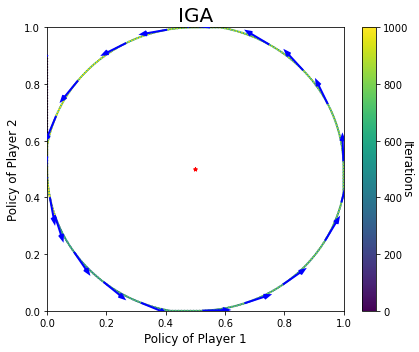

IGA Done


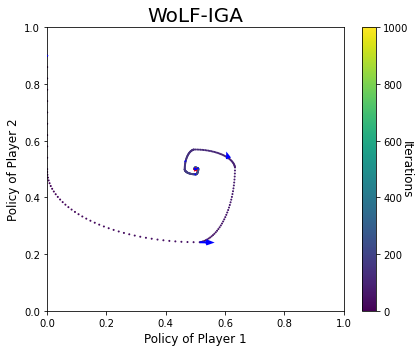

WoLF-IGA Done


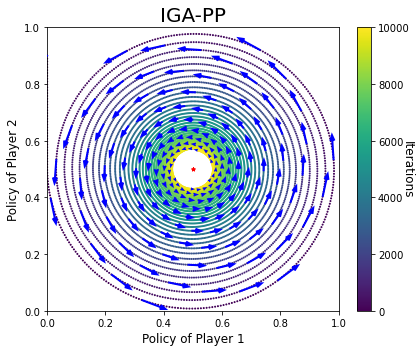

IGA-PP Done


In [10]:
agents = ['IGA', 'WoLF-IGA', 'IGA-PP']

for agent in agents:

    if agent == 'IGA':
        pi_alpha_history, \
        pi_beta_history, \
        pi_alpha_gradient_history, \
        pi_beta_gradient_history = IGA(pi_alpha,
                                     pi_beta,
                                     payoff_0,
                                     payoff_1,
                                     u_alpha,
                                     u_beta,
                                     iteration=1000, # iteration number
                                     eta=0.01 # step size
                                    )
    elif agent == 'WoLF-IGA':
        pi_alpha_history, \
        pi_beta_history, \
        pi_alpha_gradient_history, \
        pi_beta_gradient_history = WoLF_IGA(pi_alpha,
                                          pi_beta,
                                          payoff_0,
                                          payoff_1,
                                          u_alpha,
                                          u_beta,
                                          pi_alpha_nash=pi_alpha_nash,
                                          pi_beta_nash=pi_beta_nash,
                                          iteration=1000, # iteration number
                                          eta_min=0.01, # min step size
                                          eta_max=0.04 # max step size 
                                         )
    
    
    elif agent == 'IGA-PP':
        pi_alpha_history, \
        pi_beta_history, \
        pi_alpha_gradient_history, \
        pi_beta_gradient_history = IGA_PP(pi_alpha,
                                        pi_beta,
                                        payoff_0,
                                        payoff_1,
                                        u_alpha,
                                        u_beta,
                                        iteration=10000, # iteration number
                                        eta=0.01, # step size
                                        gamma=0.01 # step size for policy prediction
                                       )
    
    
    plot_dynamics(pi_alpha_history,
                pi_beta_history,
                pi_alpha_gradient_history,
                pi_beta_gradient_history,
                agent)
    print('{} Done'.format(agent))

## Part II: Stochastic Game  (10 points)

### Problem Description

In this part, you are required to implement two agent to play the Stochastic Game, which has non-monotonicity reward and requires exploration to achieve the global optimal. 

There are $3$ intermediate states before arriving at the final state. The game transition and reward matrices are:

![Stochastic Game](https://raw.githubusercontent.com/mlii/mvrl/master/data/sg.png)

Given an initial reward matrix (shown in the middle of the above plot), the choice of joint action leads to different branches. For example, the joint action pair (0, 0) will lead to the left branch, while the joint action pair (1, 1) will lead to the branch on the right. Agents can observe the current step number and branch. Zero rewards lead to the termination state (shown as the red cross).

The optimal policy is to take the top left action pair (0, 0), and finally take the bottom right action pair (1, 1), resulting in a optimal total payoff of $8$.

This game is not easy, because it needs $3$-step exploration to discover the optimal policy, and is hard to deviate from sub-optimal (the right branch). Thus, using a strategic exploration approach is necessary.


In [11]:
import numpy as np


class StochasticGame():
    def __init__(self, episode_limit=5, good_branches=2, batch_size=None, **kwargs):
        # Define the agents
        self.n_agents = 2

        self.episode_limit = episode_limit

        # Define the internal state
        self.steps = 0

        r_matrix = [[1,1],[1,1]]
        self.payoff_values = [r_matrix for _ in range(self.episode_limit)]
        self.final_step_diff =[[1,1],[1,4]]

        self.branches = 4
        self.branch = 0

        self.n_actions = len(self.payoff_values[0])

        self.good_branches = good_branches

    def reset(self):
        """ Returns initial observations and states"""
        self.steps = 0
        self.branch = 0
        return self.get_obs()

    def step(self, actions):
        """ Returns reward, terminated, info """
        current_branch = 0
        if (actions[0], actions[1]) == (0,0):
            current_branch = 0
        if (actions[0], actions[1]) == (0,1):
            current_branch = 1
        if (actions[0], actions[1]) == (1,0):
            current_branch = 2
        if (actions[0], actions[1]) == (1,1):
            current_branch = 3

        if self.steps == 0:
            self.branch = current_branch

        info = {}

        info["good_payoff"] = 0
        info["branch"] = self.branch

        if self.good_branches == 4:
            reward = 1 if self.branch == current_branch else 0 # Need to follow your branch
        elif self.good_branches == 2:
            reward = 1 if self.branch in [0,3] and self.branch == current_branch else 0
        else:
            raise Exception("Environment not setup to handle {} good branches".format(self.good_branches))

        if self.episode_limit > 1 and self.steps == self.episode_limit - 1 and self.branch == 0:
            info["good_payoff"] = 1
            reward = self.final_step_diff[actions[0]][actions[1]]

        self.steps += 1

        if self.steps < self.episode_limit and reward > 0:
            terminated = False
        else:
            terminated = True

        info["episode_limit"] = False

        # How often the joint-actions are taken
        info["action_00"] = 0
        info["action_01"] = 0
        info["action_10"] = 0
        info["action_11"] = 0
        if (actions[0], actions[1]) == (0, 0):
            info["action_00"] = 1
        if (actions[0], actions[1]) == (0, 1):
            info["action_01"] = 1
        if (actions[0], actions[1]) == (1, 0):
            info["action_10"] = 1
        if (actions[0], actions[1]) == (1, 1):
            info["action_11"] = 1

        return self.get_obs(), [reward] * 2, [terminated] * 2, info

    def get_obs(self):
        """ Returns all agent observations in a list """
        one_hot_step = [0] * (self.episode_limit + 1 + self.branches)
        one_hot_step[self.steps] = 1
        one_hot_step[self.episode_limit + 1 + self.branch] = 1
        return [tuple(one_hot_step) for _ in range(self.n_agents)]

    def get_obs_agent(self, agent_id):
        """ Returns observation for agent_id """
        return self.get_obs()[agent_id]

    def get_obs_size(self):
        """ Returns the shape of the observation """
        return len(self.get_obs_agent(0))

    def get_state(self):
        return self.get_obs_agent(0)

    def get_state_size(self):
        """ Returns the shape of the state"""
        return self.get_obs_size()

    def get_total_actions(self):
        """ Returns the total number of actions an agent could ever take """
        return self.n_actions


### Example: Random Policy

A simple agent using random policy is provided below.

In [12]:
from collections import defaultdict
from functools import partial
from abc import ABCMeta, abstractmethod
import random

import numpy as np

def sample(pi):
    return np.random.choice(pi.size, size=1, p=pi)[0]

def normalize(pi):
    minprob = np.min(pi)
    if minprob < 0.0:
        pi -= minprob
    pi /= np.sum(pi)

class BaseQAgent:
    def __init__(self, name, action_num=2, phi=0.01, gamma=0.95, episilon=0.1, **kwargs):
        self.name = name
        self.action_num = action_num
        self.episilon = episilon
        self.gamma = gamma
        self.phi = phi
        self.epoch = 0
        self.Q = None
        self.pi = defaultdict(partial(np.random.dirichlet, [1.0] * self.action_num))

    def done(self):
        pass

    def act(self, observation, exploration=False):
        if exploration and random.random() < self.episilon:
            return random.randint(0, self.action_num - 1)
        else:
            return sample(self.pi[observation])

    @abstractmethod
    def update(self, observation, action, reward, next_observation, done):
        pass

    @abstractmethod
    def update_policy(self, observation, action):
        pass


### TODO: Implement an agent using Q-Learning (3 points)

Q-Learning is a single agent learning algorithm for finding optimal policies in MDPs. The key updating rule is as follwings:

$$
Q(s, a) \leftarrow(1-\phi) Q(s, a)+\phi\left(r+\gamma V\left(s^{\prime}\right)\right)
$$

where,
$$
V(s)=\max\left(\left[Q(s, a)_{a \in \mathcal{A}}\right]\right)
$$

In [42]:
class QAgent(BaseQAgent):
    def __init__(self, **kwargs):
        super().__init__('QAgent', **kwargs)
        self.Q = defaultdict(partial(np.random.rand, self.action_num))
        self.R = defaultdict(partial(np.zeros, self.action_num))
        self.count_R = defaultdict(partial(np.zeros, self.action_num))

    def done(self):
        self.R.clear()
        self.count_R.clear()

    def update(self, observation, action, reward, next_observation, done):
        self.count_R[observation][action] += 1.0
        self.R[observation][action] += (reward - self.R[observation][action]) / self.count_R[observation][action]

        if done:
            ########### TODO:Implement Q-Learning (Q updating for termination) (1 point) ###########
            V = 0  # the quality of state s' is 0 because it is a terminal state
            self.Q[observation][action] = (1 - self.phi)*self.Q[observation][action] + self.phi*(reward + self.gamma*V)
            ########### END TODO #####################################################
        else:
            ########### TODO:Implement Q-Learning (Q updating) (1 point) ###########
            V = self.val(next_observation)
            self.Q[observation][action] = (1 - self.phi)*self.Q[observation][action] + self.phi*(reward + self.gamma*V)
            ########### END TODO #####################################################
        self.update_policy(observation, action)
        self.epoch += 1

    def val(self, observation):
        ########### TODO:Implement Q-Learning (V) (1 point) ###########
        Q_s = self.Q[observation]
        v = np.max(Q_s)
        ########### END TODO ##########################################
        return v

    def update_policy(self, observation, action):
        Q = self.Q[observation]
        self.pi[observation] = (Q == np.max(Q)).astype(np.double)
        self.pi[observation] = self.pi[observation] / np.sum(self.pi[observation])

### Test your Q agents on the Stochastic Game

In [43]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from copy import deepcopy

def rollout(env, agents, exploration=True, max_episode=30000, log_episode_interval=500, verbose=False):
    history_reward = []
    state_n = env.reset()
    episode_reward = 0
    episode_count = 0
    recorded_episodes = []
    recorded_episode_reward = []
    while episode_count < max_episode:
        actions = np.array([agent.act(state, exploration) for state, agent in zip(state_n, agents)])
        next_state_n, reward_n, done_n, _ = env.step(actions)
        episode_reward += np.mean(reward_n)
        for j, (state, reward, next_state, done, agent) in enumerate(zip(state_n, reward_n, next_state_n, done_n, agents)):
            agent.update(state, actions[j], reward, next_state, done)
        state_n = next_state_n
        if np.all(done_n):
            state_n = env.reset()
            history_reward.append(episode_reward)
            episode_reward = 0
            episode_count += 1
            if episode_count % log_episode_interval == 0:
                recorded_episodes.append(episode_count)
                episodes_mean_reward = np.mean(history_reward)
                recorded_episode_reward.append(episodes_mean_reward)
                history_reward = []
            if verbose:
                print('Episodes {}, Reward {}'.format(episode_count, episodes_mean_reward))
    return recorded_episodes, recorded_episode_reward

In [49]:
agent_num = 2
action_num = 2

runs = 10
log_episode_interval = 500
# store data for each run
train_recorded_episodes_log = []
train_recorded_episode_reward_log = []
test_recorded_episode_reward_log = []

for i in range(runs):
    ##################################### INITIALISATION ####################################
    agents = []
    env = StochasticGame()
    for i in range(agent_num):
#         agent = BaseQAgent(name='random', action_num=action_num)
        agent = QAgent(action_num=action_num)
        agents.append(agent)

    ####################################### TRAINING #######################################
    train_recorded_episodes, train_recorded_episode_reward = rollout(env=env, 
                                                                  agents=agents, 
                                                                  exploration=True,
                                                                  max_episode=30000,
                                                                  log_episode_interval=log_episode_interval)
    # store result for every run
    train_recorded_episodes_log.append(train_recorded_episodes)
    train_recorded_episode_reward_log.append(train_recorded_episode_reward)

    ####################################### TESTING #######################################
    test_recorded_episodes, test_recorded_episode_reward = rollout(env=env, 
                                                               agents=agents, 
                                                               exploration=False, 
                                                               max_episode=10, 
                                                               log_episode_interval=1)
    # store result for every run
    test_recorded_episode_reward_log.append(np.mean(test_recorded_episode_reward))

No handles with labels found to put in legend.


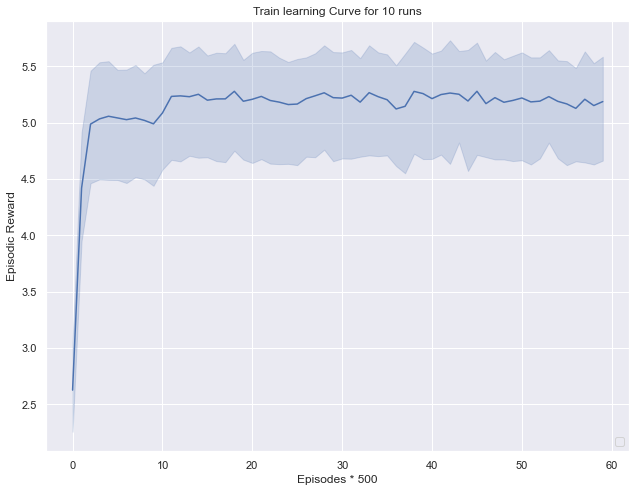

Test reward is (average over 10 runs): 7.4


In [50]:
####################################### TRAINING #######################################

import seaborn as sns; sns.set()
import pandas as pd
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111)
df_reward = pd.DataFrame(train_recorded_episode_reward_log).melt()
sns.lineplot(ax=ax, x='variable', y='value', data=df_reward)
ax.set_title(f"Train learning Curve for {runs} runs")
ax.set_ylabel("Episodic Reward")
ax.set_xlabel("Episodes * " + str(log_episode_interval))
ax.legend(loc="lower right")
plt.tight_layout()
plt.show()

####################################### TESTING #######################################
print(f'Test reward is (average over {runs} runs):', np.mean(test_recorded_episode_reward_log))

In [51]:
test_recorded_episode_reward_log

[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 5.0, 5.0]

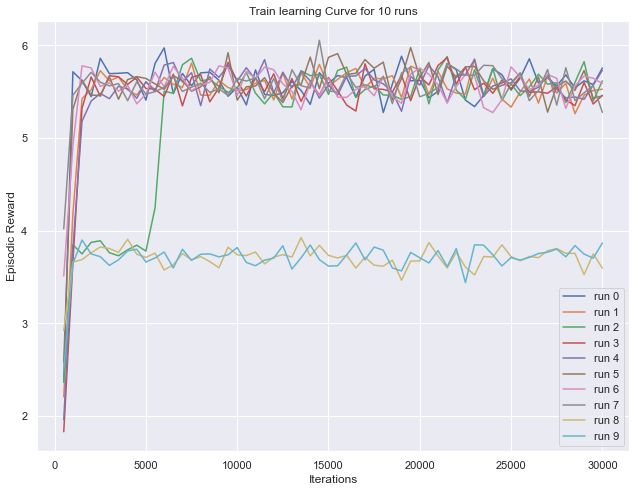

Test reward is (average over 10 runs): 7.4


In [52]:
####################################### TRAINING #######################################
# different episodes returned every time so each learning curve shown separately
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111)

for i in range(runs):
    ax.plot(train_recorded_episodes_log[i], train_recorded_episode_reward_log[i], label=f'run {i}')
ax.set_title(f"Train learning Curve for {runs} runs")
ax.set_ylabel("Episodic Reward")
ax.set_xlabel("Iterations")
ax.legend(loc="lower right")
plt.tight_layout()
plt.show()

####################################### TESTING #######################################
print(f'Test reward is (average over {runs} runs):', np.mean(test_recorded_episode_reward_log))

### TODO: Implement an Advanced Agent to solve the Stochastic Game (7 points)

Unless you are extremely lucky, the Q-learning agent implemented above is very hard to succeed in the Stochastic Game. In this part, you are required to implement a really cool agent to play the Stochastic Game. 

**Hint: You might want to use a strategic exploration approach.**

Points will be given based on the performance of your algorithm, e.g., if the test reward of your algorithm is 6, you will be given 6/8*7=5.25 points, since the optimal payoff is 8.

In [70]:
class CoolAgent(BaseQAgent):
    def __init__(self, temperature, **kwargs):
        super().__init__('CoolAgent', **kwargs)
        self.Q = defaultdict(partial(np.random.rand, self.action_num))
        self.temperature = temperature

    def done(self):
        pass

    def act(self, observation, exploration):
        """
        If we are not exploring, choose actions greedily.
        Args:
            observation: 
            exploration: 

        Returns:

        """
        if exploration:
            return sample(self.pi[observation])
        else:
            return np.argmax(self.pi[observation])

    @abstractmethod
    def update(self, observation, action, reward, next_observation, done):
        if done:
            V = 0  # the quality of state s' is 0 because it is a terminal state
            self.Q[observation][action] = (1 - self.phi)*self.Q[observation][action] + self.phi*(reward + self.gamma*V)
        else:
            V = self.val(next_observation)
            self.Q[observation][action] = (1 - self.phi)*self.Q[observation][action] + self.phi*(reward + self.gamma*V)
        self.update_policy(observation, action)
        self.epoch += 1

    def val(self, observation):
        Q_s = self.Q[observation]
        v = np.max(Q_s)
        return v

    @abstractmethod
    def update_policy(self, observation, action):
        """
        Use Boltzmann exploration.
        Args:
            observation:
            action:

        Returns: None.

        """
        Q = self.Q[observation]
        softmax = special.softmax(x=Q/self.temperature)
        self.pi[observation] = softmax

In [75]:
# Feel Free to write code here to train and tune your cool agents, 
# and assign the trained agents to cool_agents at the end
# ########################################
# TODO: Your cool agent training code #############
agent_num = 2
action_num = 2

runs = 10
cool_log_episode_interval = 500
# store data for each run
train_cool_recorded_episodes_log = []
train_cool_recorded_episode_reward_log = []
test_cool_recorded_episode_reward_log = []
temperature = 2

for i in range(runs):
    ##################################### INITIALISATION ####################################
    agents = []
    env = StochasticGame()
    for i in range(agent_num):
        agent = CoolAgent(action_num=action_num, temperature=temperature)
        agents.append(agent)

    ####################################### TRAINING #######################################
    train_cool_recorded_episodes, train_cool_recorded_episode_reward = rollout(env=env,
                                                                  agents=agents,
                                                                  exploration=True,
                                                                  max_episode=30000,
                                                                  log_episode_interval=cool_log_episode_interval)
    # store result for every run
    train_cool_recorded_episodes_log.append(train_cool_recorded_episodes)
    train_cool_recorded_episode_reward_log.append(train_cool_recorded_episode_reward)

    ####################################### TESTING #######################################
    cool_agents = agents
    # Cool agent evaluation code, please do not change
    cool_env = StochasticGame()
    test_cool_recorded_episodes, test_cool_recorded_episode_reward = rollout(env=cool_env,
                                                                        agents=cool_agents,
                                                                        exploration=False,
                                                                        max_episode=10,
                                                                        log_episode_interval=1)
    # store result for every run
    test_cool_recorded_episode_reward_log.append(np.mean(test_cool_recorded_episode_reward))

No handles with labels found to put in legend.


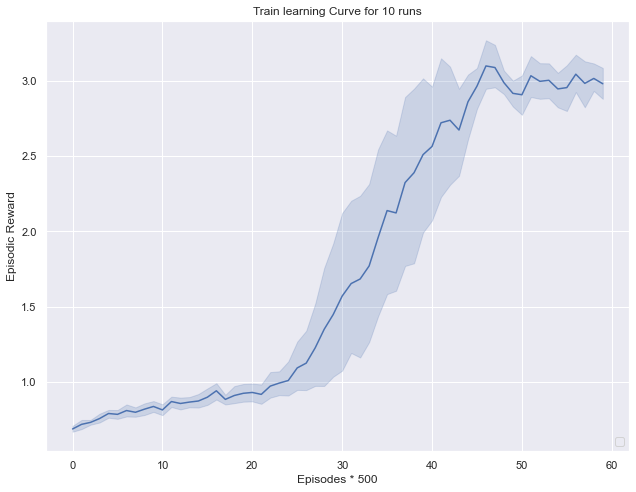

Cool agent's test reward is (average over 10 runs): 8.0


In [76]:
####################################### TRAINING #######################################
import seaborn as sns; sns.set()
import pandas as pd
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111)
df_cool_reward = pd.DataFrame(train_cool_recorded_episode_reward_log).melt()
sns.lineplot(ax=ax, x='variable', y='value', data=df_cool_reward)
ax.set_title(f"Train learning Curve for {runs} runs")
ax.set_ylabel("Episodic Reward")
ax.set_xlabel("Episodes * " + str(cool_log_episode_interval))
ax.legend(loc="lower right")
plt.tight_layout()
plt.show()

print(f'Cool agent\'s test reward is (average over {runs} runs):', np.mean(test_cool_recorded_episode_reward_log))


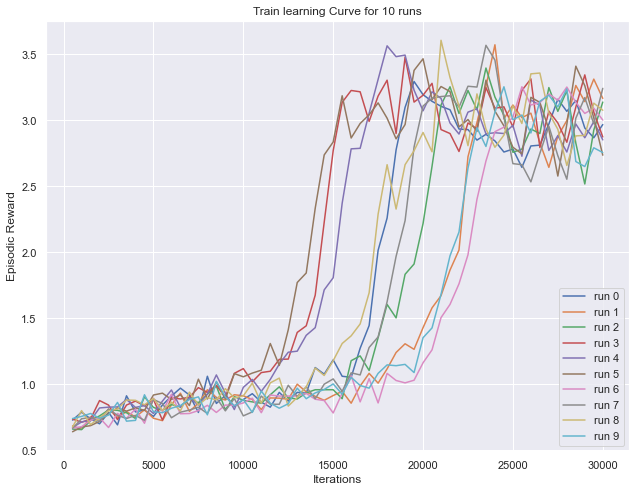

Cool agent's test reward is (average over 10 runs): 8.0


In [77]:
####################################### TRAINING #######################################
# different episodes returned every time so each learning curve shown separately
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111)

for i in range(runs):
    ax.plot(train_cool_recorded_episodes_log[i], train_cool_recorded_episode_reward_log[i], label=f'run {i}')
ax.set_title(f"Train learning Curve for {runs} runs")
ax.set_ylabel("Episodic Reward")
ax.set_xlabel("Iterations")
ax.legend(loc="lower right")
plt.tight_layout()
plt.show()

####################################### TESTING #######################################
print(f'Cool agent\'s test reward is (average over {runs} runs):', np.mean(test_cool_recorded_episode_reward_log))

In [78]:
test_cool_recorded_episode_reward_log

[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0]

Few words to analysis the results comparing to the Q Agent, and what you have did to improve the performance. (< 300 words)

**Q-Agent problems**

The epsilon-greedy exploration of the Q-Agent is not optimal. In epsilon-greedy, the agent only distinguishes between greedy and non-greedy actions. Therefore, the agent fails to pay more attention to non-greedy but potentially promising actions than non-greedy actions which the agent estimates to be largely sub-optimal.

This makes it very easy to fall into local optima, such as taking the right branch. 

**Boltzmann agent solutions**

I have used Boltzmann exploration to address this shortcoming. In Boltzmann exploration, the probability of choosing an action given a state is:

$\pi_t(a|s) = \frac{exp(Q_t(s, a)/\tau)}{\sum_{b=1}^{k} exp(Q_t(s, b)/\tau)}$

Where $\tau$ is the positive temperature parameter. A larger $\tau$ “flattens” the softmax distribution and promotes exploration. Whereas a smaller $\tau$ promotes greedy action selection. The temperature parameter can be annealed over time but in this specific game, it was sufficient to use a constant $\tau$. $\tau$ = 2 was chosen following a hyperparameter search.

The softmax policy helps the agent avoid being trapped in suboptimal policies. 

**Comparing the results** 

From the train learning curve for the Q-Agent, one can see that the epsilon-greedy behaviour hinders exploration. The agent either gets stuck in a sub-optimal policy with a reward of 5, or luckily finds the optimal policy with a reward of 8.  However, after this initial convergence, there is little chance for exploration (only run 2 manages to escape the local optimum, whereas run 8 and run 9 stay stuck).

Conversely, for the train learning curve for the Boltzmann agent, one can see that the agent is exploring extensively for at least 15,000 episodes across all 10 runs. This increased exploration allows it to find the optimal policy with a reward of 8. When exploration=False during testing, the agent can greedily choose this optimal policy.




## Part III: Cournot Duopoly (12 points)

Cournot Duopoly is a classic static game that models the imperfect competition in which multiple firms compete in price and production to capture market share.
Since the firms' actions are continuous variables, the game is a continuous action setting.
It is a **nonzero-sum game** (neither team-based nor zero-sum) which represents a challenge for current MARL methods.

Let $a_i\in [-A_i,A_i]$ represents the set of actions for agent $i\in\{1,2\ldots, N\}:=\mathcal{N}$,
where $A_i\in \mathbb{R}_{>0}$.
Each agent $i$'s reward (profit) is 
$$
R_i(a_i,a_{-i})=g_i(a_i,a_{-i})+ w_i(a_i),
$$
where
$
\partial^{2} g_{i} / \partial a_{i}^{2}<0, \partial g_{i} / \partial a_{-i}<0
$,and 
$\partial^{2} g_{i} / \partial a_{i} \partial a_{-i}<0
$.
Agents adopt Markov policies as
$
a_{i} = \pi_i(a_{-i}).
$


#### TODO: Assume $N=2$, prove that policy $\pi_i$ is non-increasing. (5 points)



As $N=2$, we can define the agents as $i \in \{1,2\}$.

To prove that $\pi_i$ is non-increasing, we want to prove:

$\frac{d\pi_1(a_2)}{da_2} = \frac{da_1}{da_2} \leq 0$

By definition of the policy:

$a_1 = \pi_1(a_2) = \underset{a_1}{\operatorname{argmax}} R_1(a_1, a_2) $

As $a_1$ maximises $R_1(a_1, a_2)$:

$\frac{\partial R_1(a_1, a_2)}{\partial a_1} |_{a_1=\pi_1(a_2)} = 0$

We perform implicit differentiation on both sides:

$\frac{d}{da_2} (\frac{\partial R_1(a_1, a_2)}{\partial a_1}) = 0$

Using the chain rule:

$\frac{\partial}{\partial a_1} [ \frac{\partial R_1(a_1, a_2)}{\partial a_1} ] \frac{da_1}{da_2} + \frac{\partial}{\partial a_2} [ \frac{\partial R_1(a_1, a_2)}{\partial a_1} ]  \frac{da_2}{da_2} = 0$

$\frac{\partial^2 R_1(a_1, a_2)}{\partial a_1^2} \frac{da_1}{da_2} + \frac{\partial^2 R_1(a_1, a_2)}{\partial a_1 \partial a_2} = 0$

$\frac{da_1}{da_2} = - \frac{\partial^2 R_1(a_1, a_2)}{\partial a_1 \partial a_2} (\frac{\partial^2 R_1(a_1, a_2)}{\partial a_1^2} )^{-1}$

We investigate $\frac{\partial^2 R_1(a_1, a_2)}{\partial a_1 \partial a_2}$:

$\frac{\partial^2 R_1(a_1, a_2)}{\partial a_1 \partial a_2} = \frac{\partial^2 g_1(a_1, a_2)}{\partial a_1 \partial a_2} + \frac{d}{da_2} \frac{dw_1(a_1)}{da_1}$

$\frac{d}{da_2} \frac{dw_1(a_1)}{da_1} = 0$ because $w_1(a_1)$ is not a function of $a_2$

Therefore: 

$\frac{\partial^2 R_1(a_1, a_2)}{\partial a_1 \partial a_2} = \frac{\partial^2 g_1(a_1, a_2)}{\partial a_1 \partial a_2}$

As it is given $\frac{\partial^2 g_i(a_i, a_{-i})}{\partial a_i \partial a_{-i}} < 0$:

$\frac{\partial^2 R_1(a_1, a_2)}{\partial a_1 \partial a_2} < 0$

Now we investigate $\frac{\partial^2 R_1(a_1, a_2)}{\partial a_1^2}$

$\frac{\partial^2 R_1(a_1, a_2)}{\partial a_1^2} = \frac{\partial^2 g_1(a_1, a_2)}{\partial a_1^2} + \frac{d^2 w_1(a_1)}{da_1^2}$

$w_i(a_i)$ resembles the cost function of the Cournot model. We now assume $w_i(a_i)$ is linear in $a_i$. This corresponds to a constant marginal cost. Therefore:

$\frac{d^2 w_1(a_1)}{da_1^2} = 0$

and 

$
\begin{align}
\frac{\partial^2 R_1(a_1, a_2)}{\partial a_1^2} &= \frac{\partial^2 g_1(a_1, a_2)}{\partial a_1^2} \\
&< 0 \\
\end{align}
$

Therefore $\frac{da_1}{da_2} = - \frac{\partial^2 R_1(a_1, a_2)}{\partial a_1 \partial a_2} (\frac{\partial^2 R_1(a_1, a_2)}{\partial a_1^2} )^{-1} < 0$.

Therefore the policy $\pi_i$ has been proved to be decreasing. As non-increasing is softer than decreasing, the policy $\pi_i$ has also been proven to be non-increasing.

#### TODO: Set up Cournot Duopoly game. (2 points)



Suppose that 
$$
g_i=a_i(\alpha -\beta\sum_{j\in\mathcal{N}}a_j),
w_i=\gamma a_i.
$$
We choose $A_i=1.0, \forall i\in\mathcal{N}$ and $\alpha=1.5, \beta=1.0, \gamma=-0.5$.

In [76]:
import numpy as np
import gym

class CournotDuopoly(gym.Env):
    def __init__(self, agent_num=2, action_range=(-1., 1.)):
        self.agent_num = agent_num
        self.action_space = gym.spaces.Box(low=-1.0, high=1.0, shape=(1,))
        self.rewards = np.zeros((self.agent_num,))
        self.t = 0

        self.alpha = 1.5
        self.beta = 1.0
        self.gamma = -0.5

        def payoff_n_cournot(action_n, i):
            """
            Define the payoff function R_i(a_i,a_{-i}).
            :param action_n: (nd.array) a list of all agents' actions, shape is (agent_num,)
            :param i: agent index
            :return: R_i(a_i,a_{-i})
            """
            ########### TODO: Compute R_i(a_i,a_{-i}) (1 point) ###########
            g = action_n[i] * (self.alpha - self.beta*np.sum(action_n))
            w = self.gamma * action_n[i]
            r = g + w
            ########### END TODO ############################
            return r

        def payoff_n_cournot_derivative(action_n, i):
            """
            Define the partial derivative of the payoff function R_i(a_i,a_{-i}) w.r.t. a_i.
            :param action_n: (nd.array) a list of all agents' actions, shape is (agent_num,)
            :param i: agent index
            :return: \partial R_i(a_i,a_{-i}) / \partial a_i
            """
            ########### TODO: Compute \partial R_i(a_i,a_{-i}) / \partial a_i (1 point) ###########
            dr = self.alpha - self.beta*(np.sum(action_n) + action_n[i]) + self.gamma
            ########### END TODO ############################
            return dr
        
        self.payoff = payoff_n_cournot
        self.payoff_n_derivative = payoff_n_cournot_derivative

    def step(self, action_n):
        """
        Define the environment step function.
        :param action_n: (nd.array) a list of all agents' actions, shape is (agent_num,)
        :return: state_n: (nd.array) a list of all agents' actions, shape is (agent_num,)
        :return: reward_n: (nd.array) a list of all agents' states, shape is (agent_num,)
        :return: done_n: (nd.array) a list of all agents' done status, shape is (agent_num,)
        :return: info: (dict) a dictionary of customized information
        """
        actions = np.array(action_n).reshape((self.agent_num,))
        reward_n = np.zeros((self.agent_num,))
        payoff_derivative_n = np.zeros((self.agent_num,))
        for i in range(self.agent_num):
            payoff_derivative_n[i] = self.payoff_n_derivative(actions, i)
            reward_n[i] = self.payoff(actions, i)
        self.rewards = reward_n
#         state_n = np.array(list([[0.0 * i] for i in range(self.agent_num)]))
        state_n = actions
        info = {'reward_n': reward_n, 'reward_n_derivative': payoff_derivative_n}
        done_n = np.array([True] * self.agent_num)
        self.t += 1
        # print("state_n, reward_n, done_n, info", state_n, reward_n, done_n, info)
        return state_n, reward_n, done_n, info

    def reset(self):
        return np.array(list([[0.0 * i] for i in range(self.agent_num)]))

    def get_rewards(self):
        return self.rewards
    
    def render(self, mode="human", close=False):
        pass

    def terminate(self):
        pass


#### TODO: Implement MADDPG agents to play the Cournot Duopoly Game. (3 points)


Implement the MADDPG algorithm presented in the paper:
[Multi-Agent Actor-Critic for Mixed Cooperative-Competitive Environments](https://arxiv.org/pdf/1706.02275.pdf).

In [80]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import os

class Actor(nn.Module):
    def __init__(self):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(1, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.action_out = nn.Linear(64, 1)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        actions = torch.tanh(self.action_out(x))
        return actions


class Critic(nn.Module):
    def __init__(self, obs_shape, action_shape):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(obs_shape + action_shape, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.q_out = nn.Linear(64, 1)

    def forward(self, state, action):
        state = torch.cat(state, dim=1)
        action = torch.cat(action, dim=1)
        x = torch.cat([state, action], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        q_value = self.q_out(x)
        return q_value


class MADDPG:
    def __init__(self, n_agents, agent_id, obs_shape=1, action_shape=1):
        self.n_agents = n_agents
        self.agent_id = agent_id
        self.action_shape = action_shape
        self.train_step = 0
        self.lr_actor = 1e-4
        self.lr_critic = 1e-3
        self.tau = 0.01
        self.gamma = 0.95

        # create the network
        self.actor_network = Actor()
        self.critic_network = Critic(obs_shape * self.n_agents,
                                     action_shape * self.n_agents)

        # build up the target network
        self.actor_target_network = Actor()
        self.critic_target_network = Critic(obs_shape * self.n_agents,
                                            action_shape * self.n_agents)

        # load the weights into the target networks
        self.actor_target_network.load_state_dict(self.actor_network.state_dict())
        self.critic_target_network.load_state_dict(self.critic_network.state_dict())

        # create the optimizer
        self.actor_optim = torch.optim.Adam(self.actor_network.parameters(), lr=self.lr_actor)
        self.critic_optim = torch.optim.Adam(self.critic_network.parameters(), lr=self.lr_critic)

    # soft update
    def _soft_update_target_network(self):
        for target_param, param in zip(self.actor_target_network.parameters(),
                                       self.actor_network.parameters()):
            ########### TODO: Soft-update target actor network (0.5 point) ###########
            new_target_param = self.tau*param + (1 - self.tau)*target_param
            target_param.data.copy_(new_target_param)
            ########### END TODO ############################

        for target_param, param in zip(self.critic_target_network.parameters(),
                                       self.critic_network.parameters()):
            ########### TODO: Soft-update target critic network (0.5 point) ###########
            new_target_param = self.tau*param + (1 - self.tau)*target_param
            target_param.data.copy_(new_target_param)
            ########### END TODO ############################

    # update the network
    def train(self, transitions, other_agents):
        for key in transitions.keys():
            transitions[key] = torch.tensor(transitions[key], dtype=torch.float32)
        r = transitions['r_%d' % self.agent_id]
        o, u, o_next = [], [], []
        for agent_id in range(self.n_agents):
            o.append(transitions['o_%d' % agent_id])
            u.append(transitions['u_%d' % agent_id])
            o_next.append(transitions['o_next_%d' % agent_id])

        # calculate the target Q value function
        u_next = []
        with torch.no_grad():
            index = 0
            for agent_id in range(self.n_agents):
                if agent_id == self.agent_id:
                    u_next.append(self.actor_target_network(o_next[agent_id]))
                else:
                    u_next.append(other_agents[index].actor_target_network(o_next[agent_id]))
                    index += 1
            q_next = self.critic_target_network(o_next, u_next).detach()

            ########### TODO: Calculate the target Q value function (0.5 point) ###########
            target_q = r.unsqueeze(1) + self.gamma*q_next
            ########### END TODO ############################

        # the q loss
        q_value = self.critic_network(o, u)
        ########### TODO: Calculate the critic loss (0.5 point) ###########
        critic_loss = torch.mean((target_q - q_value)**2)
        ########### END TODO ############################

        # the actor loss
        # N.B. the actions, u, stored in the replay buffer include random noise so we need to get the noiseless outputs
        # of the actor network here
        u[self.agent_id] = self.actor_network(o[self.agent_id])
        for other_agent in other_agents:
            id = other_agent.agent_id
            u[id] = other_agent.actor_network(o[id])

        ########### TODO: Calculate the actor loss (0.5 point) ###########
        actor_loss = -torch.mean(self.critic_network(o, u))
        ########### END TODO ############################
        # update the network
        self.actor_optim.zero_grad()
        actor_loss.backward()
        self.actor_optim.step()
        self.critic_optim.zero_grad()
        critic_loss.backward()
        self.critic_optim.step()

        self._soft_update_target_network()
        self.train_step += 1

    def select_action(self, o, noise_rate, epsilon):
        if np.random.uniform() < epsilon:
            u = np.random.uniform(-1.0, 1.0, self.action_shape)
        else:
            inputs = torch.tensor(o, dtype=torch.float32).unsqueeze(0)
            ########### TODO: Take action based on the actor network (0.5 point) ###########
            u = self.actor_network(inputs).numpy() + np.random.normal(loc=0, scale=noise_rate)
            ########### END TODO ############################
        return u.copy()

    def learn(self, transitions, other_agents):
        self.train(transitions, other_agents)


#### Some useful scripts (please execute).


In [74]:
import threading

class Buffer:
    def __init__(self, n_agents=5):
        self.n_agents = n_agents
        self.size = int(5e5)
        # memory management
        self.current_size = 0
        # create the buffer to store info
        self.buffer = dict()
        for i in range(self.n_agents):
            self.buffer['o_%d' % i] = np.empty([self.size, 1])
            self.buffer['u_%d' % i] = np.empty([self.size, 1])
            self.buffer['r_%d' % i] = np.empty([self.size])
            self.buffer['o_next_%d' % i] = np.empty([self.size, 1])
        # thread lock
        self.lock = threading.Lock()

    # store the episode
    def store_episode(self, o, u, r, o_next):
        idxs = self._get_storage_idx(inc=1)
        for i in range(self.n_agents):
            with self.lock:
                self.buffer['o_%d' % i][idxs] = o[i]
                self.buffer['u_%d' % i][idxs] = u[i]
                self.buffer['r_%d' % i][idxs] = r[i]
                self.buffer['o_next_%d' % i][idxs] = o_next[i]
    
    # sample the data from the replay buffer
    def sample(self, batch_size):
        temp_buffer = {}
        idx = np.random.randint(0, self.current_size, batch_size)
        for key in self.buffer.keys():
            temp_buffer[key] = self.buffer[key][idx]
        return temp_buffer

    def _get_storage_idx(self, inc=None):
        inc = inc or 1
        if self.current_size+inc <= self.size:
            idx = np.arange(self.current_size, self.current_size+inc)
        elif self.current_size < self.size:
            overflow = inc - (self.size - self.current_size)
            idx_a = np.arange(self.current_size, self.size)
            idx_b = np.random.randint(0, self.current_size, overflow)
            idx = np.concatenate([idx_a, idx_b])
        else:
            idx = np.random.randint(0, self.size, inc)
        self.current_size = min(self.size, self.current_size+inc)
        if inc == 1:
            idx = idx[0]
        return idx

def evaluate(env, agents, agent_num, evaluate_episodes, evaluate_episode_len):
    returns = []
    for episode in range(evaluate_episodes):
        # reset the environment
        s = env.reset()
        rewards_n = np.zeros(agent_num)
        rs = []
        alist = []
        rewards1 = 0
        for time_step in range(evaluate_episode_len):
            actions = []
            with torch.no_grad():
                for agent_id, agent in enumerate(agents):
                    action = agent.select_action(s[agent_id], 0, 0)
                    actions.append(action)
            s_next, r, done, info = env.step(actions)
            if type(info['reward_n']) is list:
                rewards_n += np.sum(info['reward_n'])
            else:
                rewards_n += info['reward_n'].squeeze()

            s = s_next
        returns.append(rewards_n)
    s = env.reset()
    mean_return = sum(returns) / evaluate_episodes

    return mean_return


#### Test your implemented MADDPG agent in the Cournot Duopoly Game.


  0%|          | 1/20000 [00:07<42:32:26,  7.66s/it]<ipython-input-76-9e3d7ee39095>:53: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  actions = np.array(action_n).reshape((self.agent_num,))
  1%|          | 104/20000 [00:07<17:27, 18.99it/s] 

[ -6.71919699   6.50626944   4.02216836  -9.48304838 -27.10940105]


  1%|          | 197/20000 [00:07<07:49, 42.20it/s]<ipython-input-80-0cfd391e62f3>:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  transitions[key] = torch.tensor(transitions[key], dtype=torch.float32)
  5%|▌         | 1004/20000 [00:45<2:45:43,  1.91it/s]

[ 5.26726806 -5.08442162 11.77913714  7.15535244  4.0613501 ]


 10%|█         | 2005/20000 [01:33<3:25:16,  1.46it/s]

[ 4.47748168 -2.60280085  9.93193459  4.84910549  4.43722446]


 15%|█▌        | 3005/20000 [02:23<2:38:34,  1.79it/s]

[ 4.2561359  -1.4751786   8.27396001  4.9764535   5.36897898]


 20%|██        | 4004/20000 [03:12<2:37:04,  1.70it/s]

[ 5.65872244 -1.08802964  6.82598396  4.01675804  5.10839778]


 25%|██▌       | 5004/20000 [03:59<2:21:47,  1.76it/s]

[ 6.14469641 -1.24953817  7.95704157  5.08524404  3.88474438]


 30%|███       | 6006/20000 [04:46<2:21:47,  1.64it/s]

[ 6.54817581 -2.79817018 11.01553021  7.41934651  0.46381788]


 35%|███▌      | 7005/20000 [05:25<1:21:05,  2.67it/s]

[ 7.24508207 -2.89343818  7.49850665  8.47856206  3.10120538]


 40%|████      | 8005/20000 [06:02<1:05:08,  3.07it/s]

[ 5.77774659 -3.07152913  9.31325163  7.98833725  3.26376315]


 45%|████▌     | 9003/20000 [06:40<2:00:24,  1.52it/s]

[ 5.6636334  -2.89986775  9.22032928  8.11144682  3.42042417]


 50%|█████     | 10007/20000 [07:18<1:01:03,  2.73it/s]

[ 4.94254917 -2.59564778  9.10990803  8.4362355   2.91597569]


 55%|█████▌    | 11005/20000 [07:57<59:48,  2.51it/s]  

[ 5.01341089 -2.89231077  9.93824772  8.66672762  1.75988356]


 60%|██████    | 12007/20000 [08:37<44:37,  2.98it/s]  

[ 4.04344189 -3.15108571  9.19063222  7.68093507  4.12450593]


 65%|██████▌   | 13005/20000 [09:15<50:06,  2.33it/s]  

[ 4.58092317 -3.21958361  9.336284    6.85713307  4.2834894 ]


 70%|███████   | 14006/20000 [09:55<36:29,  2.74it/s]

[ 3.36405094 -2.79847752  9.80175108  7.2410233   3.89339771]


 75%|███████▌  | 15006/20000 [10:36<32:36,  2.55it/s]

[ 3.65491551 -2.01214521 10.7798245   8.52746238  1.86639929]


 80%|████████  | 16004/20000 [11:15<24:30,  2.72it/s]

[ 3.80307088 -2.55729611  9.99468887  9.07888055  2.73486428]


 85%|████████▌ | 17004/20000 [11:52<17:10,  2.91it/s]

[ 3.72336336 -2.5866455  10.29164416  8.97033779  2.69160399]


 90%|█████████ | 18004/20000 [12:30<14:27,  2.30it/s]

[ 3.88709491 -1.86436477 10.06251617  7.86538823  2.27875017]


 95%|█████████▌| 19004/20000 [13:10<07:26,  2.23it/s]

[4.84778072 0.0808185  8.25700547 6.72681612 1.46110148]


100%|██████████| 20000/20000 [13:45<00:00, 24.24it/s]


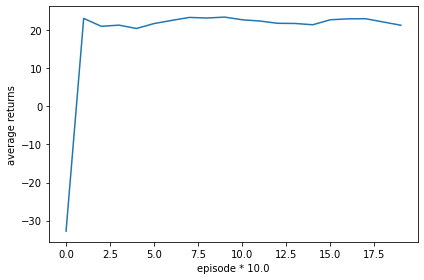

In [82]:
from tqdm import tqdm
import matplotlib.pyplot as plt

noise = 0.1
epsilon = 0.1
episode_limit = 100
n_agents = 5
batch_size = 256
evaluate_rate = 1000
time_steps = 20000
evaluate_episode_len = 100
evaluate_episodes = 100
env = CournotDuopoly(agent_num=n_agents)
agents = [MADDPG(n_agents, i, obs_shape=1, action_shape=1) for 
          i in range(n_agents)]
buffer = Buffer(n_agents=n_agents)

returns = []
done = None
mean_return_eval = 0.
for time_step in tqdm(range(time_steps)):
    if time_step % episode_limit == 0 or np.all(done):
        s = env.reset()
    u = []
    actions = []
    with torch.no_grad():
        for agent_id, agent in enumerate(agents):
            action = agent.select_action(s[agent_id], noise, epsilon)
            u.append(action)
            actions.append(action)

    s_next, r, done, info = env.step(actions)
    buffer.store_episode(s[:n_agents], u,
                         r[:n_agents], s_next[:n_agents])

    s = s_next

    if buffer.current_size >= batch_size:
        transitions = buffer.sample(batch_size)
        for agent in agents:
            other_agents = agents.copy()
            other_agents.remove(agent)
            agent.learn(transitions, other_agents)

    if time_step == 0 or time_step % evaluate_rate == 0:
        mean_return_eval = evaluate(env, agents, n_agents,
                                    evaluate_episodes, evaluate_episode_len)
        returns.append(mean_return_eval)
        print(mean_return_eval)
plt.figure()
plt.plot(range(len(returns)), np.array(returns).sum(-1))
plt.xlabel('episode * ' + str(evaluate_rate / episode_limit))
plt.ylabel('average returns')
plt.tight_layout()
plt.show()

#### TODO: Analyze the performance of your implemented MADDPG algorithm. Describe the reason if it's not playing well.(2 points)

*Hint: Cournot Monopoly is a nonzero-sum game.*

In [ ]:
# Code to brute force search for optimal score in Cournot game.

import os
import numpy as np

def payoff_n_cournot(action_n, i):
    """
    Define the payoff function R_i(a_i,a_{-i}).
    :param action_n: (nd.array) a list of all agents' actions, shape is (agent_num,)
    :param i: agent index
    :return: R_i(a_i,a_{-i})
    """
    alpha = 1.5
    beta = 1.0
    gamma = -0.5
    ########### TODO: Compute R_i(a_i,a_{-i}) (1 point) ###########
    g = action_n[i] * (alpha - beta * np.sum(action_n))
    w = gamma * action_n[i]
    r = g + w
    ########### END TODO ############################
    return r


n_agents = 5
step = 0.05
n_test_values = int(2 / step)
A = 1
scores = np.zeros((n_test_values, n_test_values, n_test_values, n_test_values, n_test_values))
for a_1_i, a_1 in enumerate(np.arange(start=-A, stop=A, step=step)):
    print(a_1)
    for a_2_i, a_2 in enumerate(np.arange(start=-A, stop=A, step=step)):
        for a_3_i, a_3 in enumerate(np.arange(start=-A, stop=A, step=step)):
            for a_4_i, a_4 in enumerate(np.arange(start=-A, stop=A, step=step)):
                for a_5_i, a_5 in enumerate(np.arange(start=-A, stop=A, step=step)):
                    action_n = np.array([a_1, a_2, a_3, a_4, a_5])
                    sum_score = 0
                    for agent_i in range(n_agents):
                        score = payoff_n_cournot(action_n=action_n, i=agent_i)
                        sum_score += score
                    scores[a_1_i, a_2_i, a_3_i, a_4_i, a_5_i] = sum_score

My implemented MADDPG algorithm converges to achieve average returns over 20. The highest average return it achieves is 23.5. Through a brute force search, it was found that the optimum score achievable in this specific Cournot game is 25. Therefore, the MADDPG algorithm performs well.

This is actually surprising because (Lowe et al. 2017) do not address the performance of MADDPG in non-zero-sum and non-cooperative games either theoretically or experimentally. All of the games in the experiments of (Lowe et al. 2017) are either fully-cooperative or zero-sum. (Mguni et al. 2021) state that MADDPG has not been proven to converge in stochastic games that are neither team nor adversarial. Yet, the Cournot monopoly is neither team-based nor zero-sum.

## Part IV: Deep Multi-Agent Reinforcement Learning (18 points)

For this part of the coursework, you will implement your choice of any deep reinforcement learning algorithms (e.g., DQN, DRQN, or PPO) in a multi-agent setting and get to see it work on the `Switch-n` environment from ma-gym. Please read [the wiki of ma-gym](https://github.com/koulanurag/ma-gym/wiki/) first.

### Environment Example
#### Switch2-v0
![Switch-2](https://raw.githubusercontent.com/koulanurag/ma-gym/master/static/gif/Switch2-v0.gif)
#### Switch4-v0
![Switch-4](https://raw.githubusercontent.com/koulanurag/ma-gym/master/static/gif/Switch4-v0.gif)

`Switch-n` is a grid world environment having `n agents` where each agent wants to move their corresponding home location (marked in boxes outlined in same colors).
Each agent receives only it's local position coordinates. The challenging part of the game is to pass through the narrow corridor through which only one agent can pass at a time. They need to coordinate to not block the pathway for the other. A reward of +5 is given to each agent for reaching their home cell. The episode ends when both agents has reached their home state or for a maximum of 100 steps in environment.

Action Space: `0: Down, 1: Left, 2: Up , 3: Right, 4: Noop`

Agent Observation : `Agent Coordinate + Steps in env.`

Best Score: `NA`

### Download Requirements and Set the Environment
The following command will download the required scripts and set up the environment. 

In [18]:
!rm -rf ma-gym  
!git clone https://github.com/koulanurag/ma-gym.git 
%cd ma-gym 
!pip install -q -e . 
!apt-get install -y xvfb python-opengl x11-utils > /dev/null 2>&1
!pip install pyvirtualdisplay > /dev/null 2>&1
!apt-get install x11-utils
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install -U gym[atari] > /dev/null 2>&1

Cloning into 'ma-gym'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 981 (delta 16), reused 32 (delta 8), pack-reused 931
Receiving objects: 100% (981/981), 3.72 MiB | 1.80 MiB/s, done.
Resolving deltas: 100% (479/479), done.
/Users/williamdavies/OneDrive - University College London/Documents/MSc Machine Learning/COMP0124/CW1/ma-gym
/bin/bash: apt-get: command not found


In [ ]:
%matplotlib inline
import gym
import ma_gym
from ma_gym.wrappers import Monitor
import matplotlib.pyplot as plt
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
from torch import nn
import torch
import copy
import numpy as np
import pandas as pd

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

#### Example of playing Switch2-v0 Using Random Policy

In [38]:
env = wrap_env(gym.make("Switch2-v0")) # Use "Switch4-v0" for the Switch-4 game
done_n = [False for _ in range(env.n_agents)]
ep_reward = 0

obs_n = env.reset()
while not all(done_n):
    obs_n, reward_n, done_n, info = env.step(env.action_space.sample())
    ep_reward += sum(reward_n)
    env.render()
env.close()
# To improve the training efficiency, render() is not necessary during the training.
# We provide the render and video code here just want to demonstrate how to debugging and analysis.
show_video()

### TODO: Implement a Deep MARL Agent to Play Switch2-v0 (12 points)
Implement your own choice of any deep MARL algorithms to play the Switch2-v0 game.

**Requirements**

*   Implement your own algorithms, rather than a simple `import` from any other existing algorithm frameworks.
* TensorFlow 2.0+ or PyTorch 1.4+ are recommended.
*   Your algorithm has to be Multi-Agent, i.e., policy input should be the observation/ state for each corresponding agent, not for all agents.

**Required contents**

*   All your codes
*   Learning Curve (reward with respect to training iterations/ episodes)
*   Description of your code and performance analysis (no more than 500 words)



#### Code for Playing Switch2-v0


In [90]:
def add_timestep_obs(coordinates_list, timestep):
    """
    Add timestep observation.
    Args:
        coordinates_list: list of lists:
        timestep: int:

    Returns:

    """
    return [[*coords, timestep] for coords in coordinates_list]


class SwitchBuffer(Buffer):
    def __init__(self, obs_shape, n_agents=5):
        """
        Have to overwrite because the original buffer class has observations of dimension 1.
        Args:
            n_agents:
        """
        super().__init__(n_agents=n_agents)
        for i in range(self.n_agents):
            self.buffer['o_%d' % i] = np.empty([self.size, obs_shape])
            self.buffer['o_next_%d' % i] = np.empty([self.size, obs_shape])


class DuellingDQNAgent:
    def __init__(self, n_agents, agent_id, n_actions, lr, obs_shape=2, action_shape=1):
        self.n_agents = n_agents
        self.agent_id = agent_id
        self.tau = 0.01
        self.gamma = 0.95
        self.action_shape = action_shape

        self.online_DQN = DuellingDQN(obs_shape, n_actions)
        self.target_DQN = DuellingDQN(obs_shape, n_actions)
        self.optimizer = torch.optim.Adam(params=self.online_DQN.parameters(), lr=lr)
        self.MSE_loss = nn.MSELoss()

    def select_action(self, observation, epsilon):
        """
        Epsilon-greedy.
        Args:
            observation:
            epsilon:

        Returns:

        """
        if np.random.uniform() < epsilon:
            action = np.random.choice(a=self.online_DQN.n_actions)
        else:
            inputs = torch.tensor(observation, dtype=torch.float32).unsqueeze(0)
            Q_values = self.online_DQN.forward(inputs)
            action = torch.argmax(Q_values).item()
        return action

    def train(self, local_batch):
        """
        Train on experience replay batch.
        Args:
            local_batch:

        Returns:

        """
        loss = self.compute_loss(local_batch)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self._soft_update_target_network()

    def compute_loss(self, local_batch):
        """
        Compute loss between current DQN and target DQN networks.
        Args:
            o:
            o_next:
            r:

        Returns:

        """
        o, u, r, o_next = local_batch['o_%d' % self.agent_id], local_batch['u_%d' % self.agent_id], local_batch['r_%d' % self.agent_id], local_batch['o_next_%d' % self.agent_id]
        o = torch.FloatTensor(o)
        u = torch.LongTensor(u)
        r = torch.FloatTensor(r)
        o_next = torch.FloatTensor(o_next)

        current_Q = self.online_DQN.forward(observation=o)
        current_Q = current_Q.gather(1, u)  # filter by action taken
        current_Q = current_Q.squeeze(1)

        next_Q = self.target_DQN.forward(observation=o_next)
        target_Q = r + self.gamma*torch.max(input=next_Q, dim=1)[0]

        loss = self.MSE_loss(current_Q, target_Q)
        return loss

    def _soft_update_target_network(self):
        for target_param, online_param in zip(self.target_DQN.parameters(),
                                              self.online_DQN.parameters()):
            new_target_param = self.tau*online_param + (1 - self.tau)*target_param
            target_param.data.copy_(new_target_param)


class DuellingDQN(nn.Module):
    def __init__(self, observation_dim, n_actions):
        super().__init__()
        self.observation_dim = observation_dim
        self.n_actions = n_actions

        self.feature_layer = nn.Sequential(
            nn.Linear(self.observation_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU()
        )

        self.value_stream = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

        self.advantage_stream = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, self.n_actions)
        )

    def forward(self, observation):
        features = self.feature_layer(observation)
        values = self.value_stream(features)
        advantages = self.advantage_stream(features)
        qvals = values + (advantages - advantages.mean())

        return qvals


def switch_evaluate(env, max_timesteps, agents, n_agents, n_evaluation_episodes, epsilon, render=False):
    """
    Evaluate agents.
    Args:
        env:
        agents:
        n_agents:
        n_evaluation_episodes:

    Returns:

    """
    episode_rewards = np.zeros(n_evaluation_episodes)
    episode_n_agents_reached_targets = np.zeros(n_evaluation_episodes)
    for episode in range(n_evaluation_episodes):
        episode_reward = 0
        reached_goal = np.zeros(n_agents, dtype=bool)

        obs_n = env.reset()
        timestep = 0
        obs_n = add_timestep_obs(coordinates_list=obs_n, timestep=timestep)
        done_n = [False] * n_agents
        while not all(done_n):
            actions = select_actions(agents=agents, obs_n=obs_n, epsilon=epsilon)

            obs_n_next, reward_n, done_n, _ = env.step(actions)
            timestep += 1
            obs_n_next = add_timestep_obs(obs_n_next, timestep)
            obs_n = obs_n_next

            # N.B. at timestep == max_timesteps done_n are all set to True even if agents have not reached their goals
            if timestep < max_timesteps:
                reached_this_timestep = reached_goal != np.array(done_n)
                if reached_this_timestep.any():
                    reached_goal = np.array(done_n)
                    print(f'[timestep {timestep}] Agent(s) that reached goal at this timestep: {reached_this_timestep.nonzero()[0]}')
                    print(f'[timestep {timestep}] reward_n: {reward_n}')

            episode_reward += np.sum(reward_n)

            if render:
                env.render()

        episode_rewards[episode] = episode_reward
        episode_n_agents_reached_targets[episode] = reached_goal.sum()

    mean_reward = np.mean(episode_rewards)
    mean_n_agents_reached_target = np.mean(episode_n_agents_reached_targets)
    return mean_reward, mean_n_agents_reached_target


def do_experience_replay(agents, buffer):
    """
    Uniformly sampled experience replay.
    """
    batch = buffer.sample(batch_size)
    for agent in agents:
        local_batch = {k: v for k, v in batch.items() if k.endswith(str(agent.agent_id))}
        agent.train(local_batch)


def select_actions(agents, obs_n, epsilon):
    """
    Each agent selects an action. Return actions_n.
    Args:
        agents:
        obs_n:
        epsilon:

    Returns:

    """
    actions = []
    with torch.no_grad():
        for agent_id, agent in enumerate(agents):
            action = agent.select_action(obs_n[agent_id], epsilon)
            actions.append(action)
    return actions

In [ ]:
# TRAINING

# epsilon hyperparameters
def get_epsilon(timestep):
    initial_epsilon = 0.4
    current_epsilon = initial_epsilon*np.exp(-timestep/50)
    min_epsilon = 0.01
    return max(current_epsilon, min_epsilon)

max_timesteps = 50  # default is not 100 as suggested by docs
env = gym.make("Switch2-v0", max_steps=max_timesteps)  # Use "Switch4-v0" for the Switch-4 game
n_agents = env.n_agents
obs_shape = env.observation_space[0].shape[0] + 1  # + 1 because of timestep
lr = 1e-3
agents = [DuellingDQNAgent(n_agents, i, obs_shape=obs_shape, n_actions=env.action_space[0].n, lr=lr) for
          i in range(n_agents)]
buffer = SwitchBuffer(n_agents=env.n_agents, obs_shape=obs_shape)
batch_size = 256
DOWN, LEFT, UP, RIGHT, NOOP = 0, 1, 2, 3, 4

n_episodes = 750

training_rewards = np.zeros(n_episodes)
training_n_agents_reached_target = np.zeros_like(training_rewards)

greedy_evaluation_rate = 25  # evaluate every n episodes
n_evaluation_episodes = 3
greedy_evaluated_episodes = np.arange(start=0, stop=n_episodes, step=greedy_evaluation_rate)
greedy_rewards = np.zeros_like(greedy_evaluated_episodes)
greedy_n_agents_reached_target = np.zeros_like(greedy_evaluated_episodes)
for i_episode in range(n_episodes):
    episode_reward = 0
    reached_goal = np.zeros(n_agents, dtype=bool)

    obs_n = env.reset()
    timestep = 0
    obs_n = add_timestep_obs(coordinates_list=obs_n, timestep=timestep)
    done_n = [False] * n_agents
    print(f'episode: {i_episode+1}')
    while not all(done_n):
        # print(f'timestep: {timestep}')

        actions = select_actions(agents=agents, obs_n=obs_n, epsilon=get_epsilon(timestep))
        # print(f'actions: {actions}')

        obs_n_next, reward_n, done_n, _ = env.step(actions)
        timestep += 1
        obs_n_next = add_timestep_obs(obs_n_next, timestep)
        reward_to_store = [np.sum(reward_n)] * n_agents  # to promote cooperation
        buffer.store_episode(obs_n[:n_agents], actions,
                              reward_to_store, obs_n_next[:n_agents])

        obs_n = obs_n_next

        if buffer.current_size >= batch_size:
            do_experience_replay(agents=agents, buffer=buffer)

        # N.B. at timestep == max_timesteps done_n are all set to True even if agents have not reached their goals
        if timestep < max_timesteps:
            reached_this_timestep = reached_goal != np.array(done_n)
            if reached_this_timestep.any():
                reached_goal = np.array(done_n)
                print(f'[timestep {timestep}] Agent(s) that reached goal at this timestep: {reached_this_timestep.nonzero()[0]}')
                print(f'[timestep {timestep}] reward_n: {reward_n}')

        episode_reward += sum(reward_n)

    if i_episode % greedy_evaluation_rate == 0:
        mean_reward, mean_n_agents_reached_target = switch_evaluate(env=env,
                                                                    max_timesteps=max_timesteps,
                                                                    agents=agents,
                                                                    n_agents=n_agents,
                                                                    n_evaluation_episodes=n_evaluation_episodes,
                                                                    epsilon=0)
        greedy_rewards[i_episode // greedy_evaluation_rate] = mean_reward
        greedy_n_agents_reached_target[i_episode // greedy_evaluation_rate] = mean_n_agents_reached_target

    training_rewards[i_episode] = episode_reward
    training_n_agents_reached_target[i_episode] = reached_goal.sum()
env.close()

#### Plot the Learning Curve

In [115]:
def plot_result(results, train_window=10, greedy_window=10):
    # Training learning curve
    plt.figure()
    plt.title('Train reward')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(results['training_rewards'])
    plt.show()

    plt.figure()
    plt.title('Train reward')
    plt.xlabel('Episode')
    plt.ylabel('Smoothed Reward')
    smoothed = pd.DataFrame(results['training_rewards'])
    plt.plot(smoothed.rolling(window=train_window, center=True).mean())
    plt.show()

    # Training number of agents reached target
    plt.figure()
    plt.title('Train number of agents reached target')
    plt.xlabel('Episode')
    plt.ylabel('Number of agents reached target')
    plt.plot(results['training_n_agents_reached_target'])
    plt.show()

    plt.figure()
    plt.title('Train number of agents reached target')
    plt.xlabel('Episode')
    plt.ylabel('Smoothed number of agents reached target')
    smoothed = pd.DataFrame(results['training_n_agents_reached_target'])
    plt.plot(smoothed.rolling(window=train_window, center=True).mean())
    plt.show()

    # Greedy learning curve
    plt.figure()
    plt.title('Greedy reward')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(results['greedy_evaluated_episodes'], results['greedy_rewards'])
    plt.show()

    plt.figure()
    plt.title('Greedy reward')
    plt.xlabel('Episode')
    plt.ylabel('Smoothed reward')
    smoothed = pd.DataFrame(results['greedy_rewards']).rolling(window=greedy_window, center=True).mean()
    plt.plot(results['greedy_evaluated_episodes'], smoothed.to_numpy())
    plt.show()

    # Greedy number of agents reached target
    plt.figure()
    plt.title('Greedy number of agents reached target')
    plt.xlabel('Episode')
    plt.ylabel('Number of agents reached target')
    plt.plot(results['greedy_evaluated_episodes'], results['greedy_n_agents_reached_target'])
    plt.show()

    plt.figure()
    plt.title('Greedy number of agents reached target')
    plt.xlabel('Episode')
    plt.ylabel('Smoothed number of agents reached target')
    smoothed = pd.DataFrame(results['greedy_n_agents_reached_target']).rolling(window=greedy_window, center=True).mean()
    plt.plot(results['greedy_evaluated_episodes'], smoothed.to_numpy())
    plt.show()

In [102]:
import os

# I ran many experiments and saved the results. Here are the helper functions to load the results and weights of the agent networks.
# Please do feel free to re-run, but my experiments took up to an hour to run for switch-4 (3000 training episodes).

def load_results(base_dir, experiment_number, prefix='experiment_'):
    experiment_dir = os.path.join(base_dir, f'{prefix}{experiment_number}')

    results = {}

    for file in os.listdir(experiment_dir):
        if file.endswith(".npy"):
            variable_name = os.path.splitext(file)[0]
            results[variable_name] = np.load(os.path.join(experiment_dir, file))
    
    return results

def load_agents(base_dir, experiment_number, n_agents, prefix='experiment_'):
    agents = [DuellingDQNAgent(n_agents, i, obs_shape=3, n_actions=5, lr=1e-3) for
          i in range(n_agents)]

    experiment_dir = os.path.join(base_dir, f'{prefix}{experiment_number}')
    for i, agent in enumerate(agents):
        onlinemodel_state_dict = torch.load(f=os.path.join(experiment_dir, f'agent_{i}_onlinemodel.pt'))
        targetmodel_state_dict = torch.load(f=os.path.join(experiment_dir, f'agent_{i}_targetmodel.pt'))
        agent.online_DQN.load_state_dict(onlinemodel_state_dict)
        agent.target_DQN.load_state_dict(targetmodel_state_dict)

    return agents

In [103]:
base_dir = "/Users/williamdavies/OneDrive - University College London/Documents/MSc Machine Learning/COMP0124/CW1/"
results = load_results(base_dir=base_dir, experiment_number=30, prefix='experiment_')
print(results.keys())
agents = load_agents(base_dir=base_dir, n_agents=2, experiment_number=30, prefix='experiment_')
print(agents)

dict_keys(['greedy_rewards', 'training_rewards', 'training_n_agents_reached_target', 'greedy_n_agents_reached_target', 'greedy_evaluated_episodes'])
[<__main__.DuellingDQNAgent object at 0x7fbcfd2d0880>, <__main__.DuellingDQNAgent object at 0x7fbcfd0e7940>]


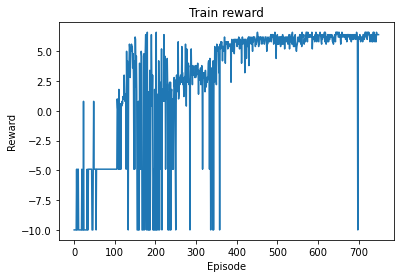

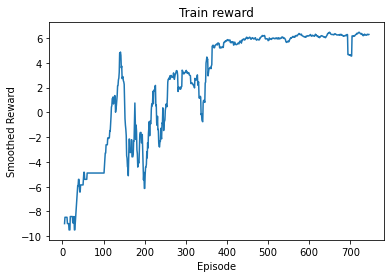

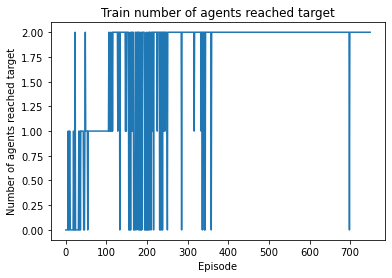

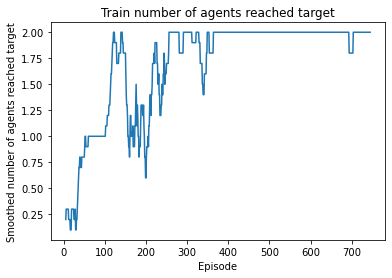

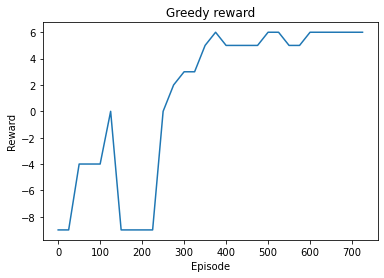

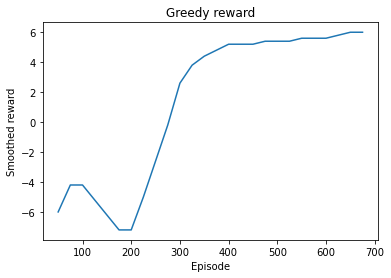

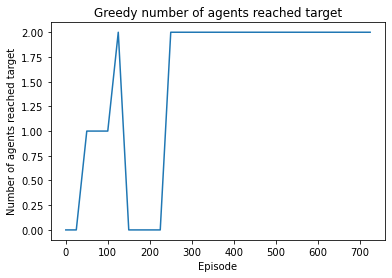

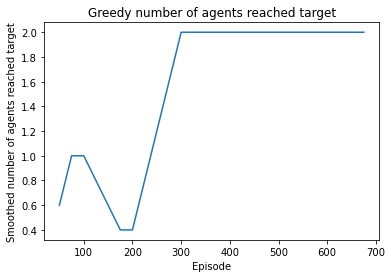

In [117]:
plot_result(results, train_window=10, greedy_window=5)

Here is also a video showing the near optimal performance of the agents when acting greedily. The reward acheived (6.4) is also printed.

In [ ]:
env = wrap_env(gym.make("Switch2-v0")) # Use "Switch4-v0" for the Switch-4 game
max_timesteps = 50
n_agents = env.n_agents
mean_reward, mean_n_agents_reached_targets = switch_evaluate(env=env, max_timesteps=max_timesteps, agents=agents, n_agents=n_agents, n_evaluation_episodes=1, render=True, epsilon=0)
env.close()

print(f'mean_reward: {mean_reward}')
print(f'mean_n_agents_reached_targets: {mean_n_agents_reached_targets}')

show_video()

#### Analysis on performance

## 1. Full implementation

**Network architecture: Duelling DQN (Wang et al., 2016)**

The duelling network represents two separate estimators: one for the state value function $V(s;\theta,\beta)$ and one for the state-dependent action advantage function $A(s,a;\theta,\alpha)$. 

This architecture leads to better policy evaluation in the presence of many similar-valued actions. Such scenarios do arise in switch. When an agent is waiting to allow the other agent to pass along the corridor, it doesn’t really matter what the agent does, as long as it doesn’t block the corridor.

The duelling architecture consists of two streams that represent the value and advantage functions, while sharing a common fully connected feature learning module. The two streams are combined via a special aggregating layer to produce an estimate of the state-action value function $\mathcal{Q}$. 

To fit the duelling DQN, I optimise the following sequence of loss functions at iteration $i$:


$L_i(\theta_i) = \mathbb{E}_{s,a,r,s'} [\big( y_i^{DQN} - \mathcal{Q}(s, a; \theta_i) \big)^2]$


with

$y_i^{DQN} = r + \gamma \underset{a'}{\operatorname{max}} \mathcal{Q} (s', a'; \theta^-)$

Where $\theta^-$ represents the parameters of a fixed and separate target network. I used a target network with soft updates. The target network improves the stability of the algorithm.

We cannot simply add the outputs of the value and advantage streams to compute the Q-value. Simple addition leads to poor performance (please see Wang et al., 2016 for more details).

Therefore, we use the following equation for the aggregation module (i.e. we subtract the mean advantage):
 
$\mathcal{Q}(s,a;\theta,\alpha,\beta) = V(s;\theta,\beta) + \big( A(s,a;\theta,\alpha) - \frac{1}{|\mathcal{A}|} \sum_{a'} A(s,a';\theta,\alpha) \big)$

This increases the stability of the optimization.

**Reinforcement learning algorithm**

I used $\epsilon$-greedy for the behaviour policy to promote exploration.

I used experience replay for updating the online network parameters. Experience replay increases data efficiency through re-use of experience samples in multiple updates and reduces variance as uniform sampling from the replay buffer reduces the correlation among the samples used in the update.

**Hyperparameters**

For the $\epsilon$ in $\epsilon$-greedy I have used exponential decay according to:

$\epsilon = \text{max}(0.01, 0.4e^{-\frac{\text{timestep}}{50}})$

I trained the agents for 750 episodes as this was sufficient to converge to near optimal performance.

## 2. Performance analysis
The best reward possible for Switch2 is 7.8. My trained agents are able to achieve a reward of 6.4. Both agents reach their targets after 19 timesteps, vs the optimal 12. I think this performance is good.

To improve performance even closer to optimal, I think it’s really just a matter of more training. If I tweaked the epsilon hyperparameter, I would be able to promote more exploration. Then the agents would be able to find even faster strategies (which essentially would mean the second agent waits a bit less before trying to pass along the corridor). If I combine this increased exploration with longer training, allowing the agents to sample more experiences, it might be possible to get the agents to really overfit to the optimal 12-timestep game completion.

## 3. Possible improvements
1. Double DQN

2. Prioritized replay 

3. Value decomposition


### TODO: Implement a Deep MARL Agent to Play Switch4-v0 (6 points)
Implement your own choice of any deep MARL algorithms to play the Switch4-v0 game.

**Requirements**

Same reuqiremnts as Switch2-v0 game. You can put emphasis on what differences between Switch2-v0 and Switch4-v0 and what improvements you have done.



#### Code for Playing Switch4-v0


I did not have to change the agent architecture for good performance on switch4-v0. I only changed the hyperparameters.

In [ ]:
def get_epsilon(timestep):
    initial_epsilon = 0.5
    current_epsilon = initial_epsilon*np.exp(-timestep/150)
    min_epsilon = 0.01
    return max(current_epsilon, min_epsilon)

# TRAINING
max_timesteps = 50  # default is not 100 as suggested by docs
env = gym.make("Switch4-v0", max_steps=max_timesteps)  # Use "Switch4-v0" for the Switch-4 game
n_agents = env.n_agents
obs_shape = env.observation_space[0].shape[0] + 1  # + 1 because of timestep
lr = 1e-3
agents = [DuellingDQNAgent(n_agents, i, obs_shape=obs_shape, n_actions=env.action_space[0].n, lr=lr) for
          i in range(n_agents)]
buffer = SwitchBuffer(n_agents=env.n_agents, obs_shape=obs_shape)
batch_size = 256
DOWN, LEFT, UP, RIGHT, NOOP = 0, 1, 2, 3, 4

n_episodes = 3000

training_rewards = np.zeros(n_episodes)
training_n_agents_reached_target = np.zeros_like(training_rewards)

greedy_evaluation_rate = 25  # evaluate every n episodes
n_evaluation_episodes = 3
greedy_evaluated_episodes = np.arange(start=0, stop=n_episodes, step=greedy_evaluation_rate)
greedy_rewards = np.zeros_like(greedy_evaluated_episodes)
greedy_n_agents_reached_target = np.zeros_like(greedy_evaluated_episodes)
for i_episode in range(n_episodes):
    episode_reward = 0
    reached_goal = np.zeros(n_agents, dtype=bool)

    obs_n = env.reset()
    timestep = 0
    obs_n = add_timestep_obs(coordinates_list=obs_n, timestep=timestep)
    done_n = [False] * n_agents
    print(f'episode: {i_episode+1}')
    while not all(done_n):
        # print(f'timestep: {timestep}')

        actions = select_actions(agents=agents, obs_n=obs_n, epsilon=get_epsilon(timestep))
        # print(f'actions: {actions}')

        obs_n_next, reward_n, done_n, _ = env.step(actions)
        timestep += 1
        obs_n_next = add_timestep_obs(obs_n_next, timestep)
        reward_to_store = [np.sum(reward_n)] * n_agents  # to promote cooperation
        buffer.store_episode(obs_n[:n_agents], actions,
                              reward_to_store, obs_n_next[:n_agents])

        obs_n = obs_n_next

        if buffer.current_size >= batch_size:
            do_experience_replay(agents=agents, buffer=buffer)

        # N.B. at timestep == max_timesteps done_n are all set to True even if agents have not reached their goals
        if timestep < max_timesteps:
            reached_this_timestep = reached_goal != np.array(done_n)
            if reached_this_timestep.any():
                reached_goal = np.array(done_n)
                print(f'[timestep {timestep}] Agent(s) that reached goal at this timestep: {reached_this_timestep.nonzero()[0]}')
                print(f'[timestep {timestep}] reward_n: {reward_n}')

        episode_reward += sum(reward_n)

    if i_episode % greedy_evaluation_rate == 0:
        mean_reward, mean_n_agents_reached_target = switch_evaluate(env=env,
                                                                    max_timesteps=max_timesteps,
                                                                    agents=agents,
                                                                    n_agents=n_agents,
                                                                    n_evaluation_episodes=n_evaluation_episodes,
                                                                    epsilon=0)
        greedy_rewards[i_episode // greedy_evaluation_rate] = mean_reward
        greedy_n_agents_reached_target[i_episode // greedy_evaluation_rate] = mean_n_agents_reached_target

    training_rewards[i_episode] = episode_reward
    training_n_agents_reached_target[i_episode] = reached_goal.sum()
env.close()

#### Plot the Learning Curve

In [119]:
base_dir = "/Users/williamdavies/OneDrive - University College London/Documents/MSc Machine Learning/COMP0124/CW1/"
results = load_results(base_dir=base_dir, experiment_number=31, prefix='experiment_')
print(results.keys())
agents = load_agents(base_dir=base_dir, n_agents=4, experiment_number=31, prefix='experiment_')
print(agents)

dict_keys(['greedy_rewards', 'training_rewards', 'training_n_agents_reached_target', 'greedy_n_agents_reached_target', 'greedy_evaluated_episodes'])
[<__main__.DuellingDQNAgent object at 0x7fbda166a250>, <__main__.DuellingDQNAgent object at 0x7fbda1663160>, <__main__.DuellingDQNAgent object at 0x7fbda1663370>, <__main__.DuellingDQNAgent object at 0x7fbda166aa00>]


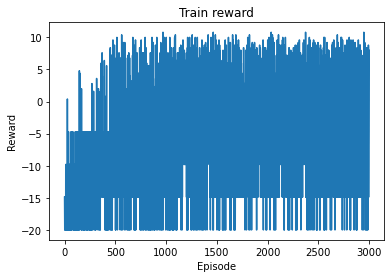

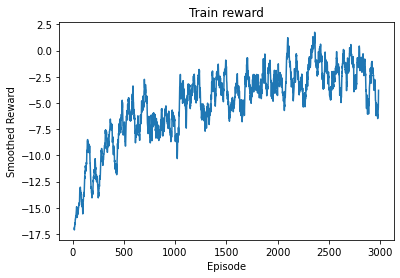

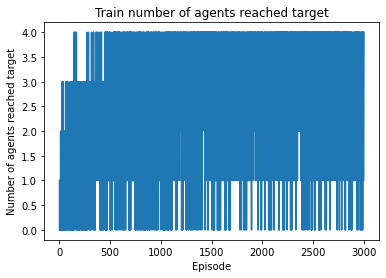

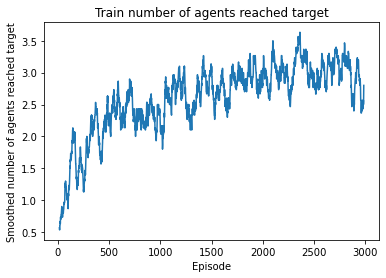

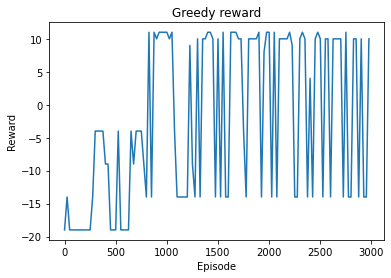

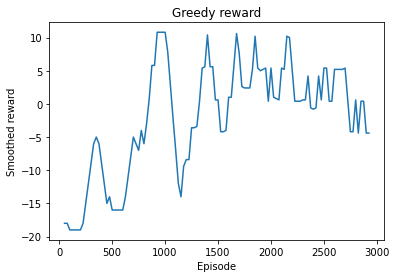

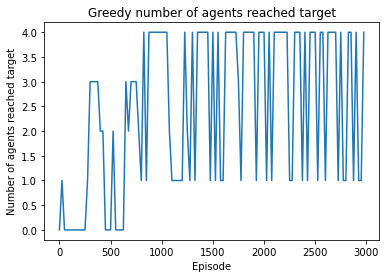

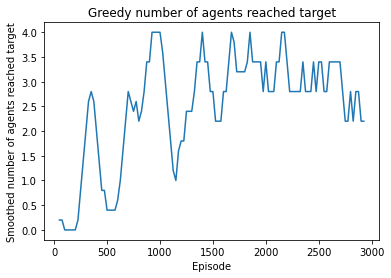

In [122]:
plot_result(results, train_window=30, greedy_window=5)

In the plots above, it's a bit difficult to see that the agents have converged to the point where all 4 agents can successfully reach the target. In the video below, it can be seen that all 4 agents are able to co-operate and quickly reach their targets. The reward is also printed.

In [ ]:
env = wrap_env(gym.make("Switch4-v0")) # Use "Switch4-v0" for the Switch-4 game
max_timesteps = 50
n_agents = env.n_agents
mean_reward, mean_n_agents_reached_targets = switch_evaluate(env=env, max_timesteps=max_timesteps, agents=agents, n_agents=n_agents, n_evaluation_episodes=1, render=True, epsilon=0)
env.close()

print(f'mean_reward: {mean_reward}')
print(f'mean_n_agents_reached_targets: {mean_n_agents_reached_targets}')

show_video()

#### Analysis on Performance

Your reports here.